# An elementary introduction to spectral audio compression

In this problem, we'll explore the very basics of audio compression in the spectral domain using numpy and scipy. We'll do a bit of visualization with matplotlib, but since that is covered later in the course, we'll provide those functions for you.

Audio compression is a large and complex topic, and the design of a format for compressed audio such as the popular [MP3](http://en.wikipedia.org/wiki/MP3) is too complex to cover in detail here. However, we will introduce the basic tools that most such compression formats use, namely:

1. Converting the input signal to the frequency domain by taking a Fast Fourier Transform (FFT).

2. Dropping information in the frequency domain, resulting in a smaller amount of data.

3. Reconstructing back the signal in the time domain from this smaller representation of the signal.

Steps 1 and 2 above are the 'encoding' part of signal compression, and step 3 is the 'decoding' part. For this reason, the tools that perform these steps are typically referred to as signal 'codecs', short for encoders/decoders.

Note that here we say 'signal': while MP3 is an audio format, the same ideas apply to the compression of digital images with formats such as JPEG and video.  Virtually all multimedia technologies we use today, from audio players to cell phones, digital cameras and YouTubeVideo, are based on sophisticated extensions and applications of these simple ideas.

Let's first load the plotting tools and importing some tools we'll need later:

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

# we'll need some path manipulations later on
import os

Populating the interactive namespace from numpy and matplotlib


We define a simple utility function to listen to audio files right in the browser:

In [2]:
def Audio(fname):
    """Provide a player widget for an audio file.
    
    Parameters
    ==========
    fname : string
      Filename to be played.
      
    Warning
    =======
    
    Browsers cache audio very aggressively. If you change an
    audio file on disk and are trying to listen to the  new version, you 
    may want to 
    """
    from IPython.display import HTML, display
    
    # Find out file extension and deduce MIME type for audio format
    ext = os.path.splitext(fname)[1].replace('.', '').lower()
    mimetype = 'audio/' + ('mpeg' if ext == 'mp3' else ext)
    
    tpl = """<p>{fname}:</p>
<audio controls>
    <source src="files/{fname}" type="{mimetype}">

Your browser does not support the Audio element; you can play 
<a href="files/{fname}">this file</a> manually.
</audio>
"""
    display(HTML(tpl.format(**locals())))

We also define a convenience wrapper around `plt.specgram`, [matplotlib's spectrogram function](http://matplotlib.org/api/mlab_api.html#matplotlib.mlab.specgram), with a colorbar and control over the color limits displayed. This will make it easier to compare across different signals with the same colors for all inputs.

In [3]:
def specgram_cbar(x, title=None, clim=(0, 80) ):
    """Plot spectrogram with a colorbar and range normalization.
    
    Call matplotlib's specgram function, with a custom figure size, 
    automatic colobar, title and custom color limits to ease 
    comparison across multiple figures.
    
    Parameters
    ==========
    x : array
      One-dimensional array whose spectrogram should be plotted.
      
    title : string
      Optional title for the figure.
      
    clim : 2-tuple
      Range for the color limits plotted in the spectrogram.
    """
    f = plt.figure(figsize=(10,3))
    plt.specgram(x)
    plt.colorbar()
    plt.clim(*clim)
    if title is not None:
        plt.title(title)
    plt.show()

## Problem 1

Use the `Audio` function above to listen to the signal we will be experimenting with, a simple voice recording stored in the file `hw_0_data/voice.wav`.

Note: if your browser doesn't support audio, you may try a different browser.   We've tested current versions of Chrome and Firefox, and it works OK with both.

In [9]:
!ls Data

im1-a.png  im2-18.png im2-31.png im2-45.png im2-59.png im2-72.png im2-86.png
im1-b.png  im2-19.png im2-32.png im2-46.png im2-6.png  im2-73.png im2-87.png
im1-c.png  im2-2.png  im2-33.png im2-47.png im2-60.png im2-74.png im2-88.png
im1-d.png  im2-20.png im2-34.png im2-48.png im2-61.png im2-75.png im2-89.png
im1-e.png  im2-21.png im2-35.png im2-49.png im2-62.png im2-76.png im2-9.png
im2-0.png  im2-22.png im2-36.png im2-5.png  im2-63.png im2-77.png im2-90.png
im2-1.png  im2-23.png im2-37.png im2-50.png im2-64.png im2-78.png im2-91.png
im2-10.png im2-24.png im2-38.png im2-51.png im2-65.png im2-79.png im2-92.png
im2-11.png im2-25.png im2-39.png im2-52.png im2-66.png im2-8.png  im2-93.png
im2-12.png im2-26.png im2-4.png  im2-53.png im2-67.png im2-80.png im2-94.png
im2-13.png im2-27.png im2-40.png im2-54.png im2-68.png im2-81.png im2-95.png
im2-14.png im2-28.png im2-41.png im2-55.png im2-69.png im2-82.png im2-96.png
im2-15.png im2-29.png im2-42.png im2-56.png im2-7.png  im2-83.png im2-97.png


In [10]:
input1 = Audio("hw_0_data/voice.wav")

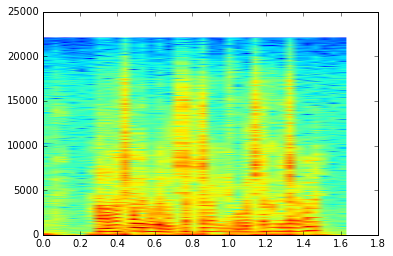

In [11]:
import pylab
from scipy.io import wavfile

fs, frames = wavfile.read("hw_0_data/voice.wav")

channels = [
    np.array(frames)
    #np.array(frames[:, 0]),
    #np.array(frames[:, 1])
]

# generate specgram
Pxx, freqs, t, plot = pylab.specgram(
    channels[0],
    NFFT=4096, 
    Fs=44100, 
    detrend=pylab.detrend_none,
    window=pylab.window_hanning,
    noverlap=int(4096 * 0.5))

## Problem 2

Write a function to compress a 1-d signal by dropping a fraction of its spectrum. 

You can drop the smallest components by setting their values to zero.

*Hints*: 

- look at the `np.fft` module, keeping in mind that your input signal is real.
- look at the `argsort` method of numpy arrays.

In [12]:
def compress_signal(x, fraction):
    """Compress an input signal by dropping a fraction of its spectrum.
    
    Parameters
    ==========
    x : array
      1-d real array to be compressed
      
    fraction : float
      A number in the [0,1] range indicating which fraction of the spectrum
      of x should be zeroed out (1 means zero out the entire signal).
      
    Returns
    =======
    x_approx : array
      1-d real array reconstructed after having compressed the input.
    """
    # your code here
    lbnd = np.percentile(x, fraction*100)
    result = ma.masked_array(x, mask = (x <= lbnd), fill_value = 0)
    return result
    

As a quick visual check (not that this is *not* a formal test of correctness), experiment with a simple random signal by changing the compression ratio and plotting both the signal and the compressed version:

In [13]:
x = np.random.rand(128)

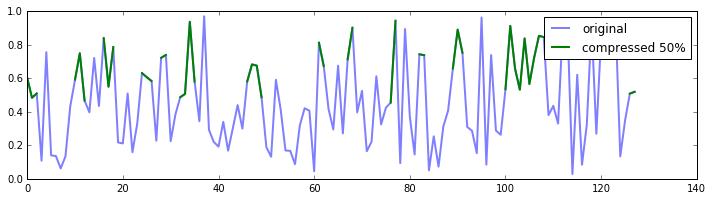

In [14]:
fraction = .5  # play changing this in the 0-1 range

xa = compress_signal(x, fraction)

plt.figure(figsize=(12,3))
plt.plot(x, alpha=0.5, lw=2, label='original')
plt.plot(xa, lw=2, label='compressed {0:.0%}'.format(fraction))
plt.legend();

## Problem 3

Write a function that will compress an audio file by a dropping a fraction of its spectrum, writing the output to a new file.

If the input file is named `a.wav` and the compression fraction is 0.9, the output file should be named `a_comp_0.9.wav`.

*Hints:* 

- look at the `scipy.io` module for routines dealing with files in `wav` format.

- you may need to use the `astype` method of numpy arrays to get the correct data type for `wav` files.

In [15]:
def compress_wav(fname, fraction):
    """Compress an audio signal stored in an input wav file.
    
    The compressed signal is returned as a numpy array and automatically written 
    to disk to a new wav file.
    
    Parameters
    ==========
    fname : string
      Name of the input wav file
      
    fraction : float
      Fraction of input data to keep.
      
    Returns
    =======
    rate : int
      Bit rate of the input signal.

    x : array
      Raw data of the original input signal.
      
    x_approx : array
      Raw data of the compressed signal.
      
    new_fname : string
      Auto-generated filename of the compressed signal.
    """
    
    # your code here
    rate, input1 = scipy.io.wavefile.read(fname)
    fname2 = "output1" #Fix it to satisfy the name requirements
    
    scipy.io.wavefile.write(fname2, rate, output)
    return([rate, x, x_appox, fanme])

In [16]:
"""Helper functions for working with audio files in NumPy."""

import numpy as np
import contextlib


def pcm2float(sig, dtype='float64'):
    """Convert PCM signal to floating point with a range from -1 to 1.
    Use dtype='float32' for single precision.
    Parameters
    ----------
    sig : array_like
        Input array, must have integral type.
    dtype : data type, optional
        Desired (floating point) data type.
    Returns
    -------
    numpy.ndarray
        Normalized floating point data.
    See Also
    --------
    float2pcm, dtype
    """
    sig = np.asarray(sig)
    if sig.dtype.kind not in 'iu':
        raise TypeError("'sig' must be an array of integers")
    dtype = np.dtype(dtype)
    if dtype.kind != 'f':
        raise TypeError("'dtype' must be a floating point type")

    i = np.iinfo(sig.dtype)
    abs_max = 2 ** (i.bits - 1)
    offset = i.min + abs_max
    return (sig.astype(dtype) - offset) / abs_max


def float2pcm(sig, dtype='int16'):
    """Convert floating point signal with a range from -1 to 1 to PCM.
    Any signal values outside the interval [-1.0, 1.0) are clipped.
    No dithering is used.
    Note that there are different possibilities for scaling floating
    point numbers to PCM numbers, this function implements just one of
    them.  For an overview of alternatives see
    http://blog.bjornroche.com/2009/12/int-float-int-its-jungle-out-there.html
    Parameters
    ----------
    sig : array_like
        Input array, must have floating point type.
    dtype : data type, optional
        Desired (integer) data type.
    Returns
    -------
    numpy.ndarray
        Integer data, scaled and clipped to the range of the given
        `dtype`.
    See Also
    --------
    pcm2float, dtype
    """
    sig = np.asarray(sig)
    if sig.dtype.kind != 'f':
        raise TypeError("'sig' must be a float array")
    dtype = np.dtype(dtype)
    if dtype.kind not in 'iu':
        raise TypeError("'dtype' must be an integer type")

    i = np.iinfo(dtype)
    abs_max = 2 ** (i.bits - 1)
    offset = i.min + abs_max
    return (sig * abs_max + offset).clip(i.min, i.max).astype(dtype)


def pcm24to32(data, channels=1, normalize=True):
    """Convert 24-bit PCM data to 32-bit.
    Parameters
    ----------
    data : buffer
        A buffer object where each group of 3 bytes represents one
        little-endian 24-bit value.
    channels : int, optional
        Number of channels, by default 1.
    normalize : bool, optional
        If ``True`` (the default) the additional zero-byte is added as
        least significant byte, effectively multiplying each value by
        256, which leads to the maximum 24-bit value being mapped to the
        maximum 32-bit value.  If ``False``, the zero-byte is added as
        most significant byte and the values are not changed.
    Returns
    -------
    numpy.ndarray
        The content of `data` converted to an `int32` array, where each
        value was padded with zero-bits in the least significant byte
        (`normalize=True`) or in the most significant byte
        (`normalize=False`).
    """
    if len(data) % 3 != 0:
        raise ValueError("Size of data must be a multiple of 3 bytes")

    out = np.zeros(len(data) // 3, dtype='<i4')
    out.shape = -1, channels
    temp = out.view('uint8').reshape(-1, 4)
    if normalize:
        # write to last 3 columns, leave LSB at zero
        columns = slice(1, None)
    else:
        # write to first 3 columns, leave MSB at zero
        columns = slice(None, -1)
    temp[:, columns] = np.frombuffer(data, dtype='uint8').reshape(-1, 3)
    return out


@contextlib.contextmanager
def printoptions(*args, **kwargs):
    """Context manager for temporarily setting NumPy print options.
    See http://stackoverflow.com/a/2891805/500098
    """
    original = np.get_printoptions()
    try:
        np.set_printoptions(*args, **kwargs)
        yield
    finally:
        np.set_printoptions(**original)